In [41]:
import pandas as pd
from typing import Any

from core.helpers import strategies
from collections import defaultdict
from core.talib_indicators import simulate_strategy

In [42]:
data = pd.read_csv("all_stocks_5yr.csv", index_col=0, parse_dates=True)

In [43]:
ticker = 'AAL'
stock_data = data[data['Name']==ticker]

In [44]:
import time

class Trade:
    MAX_SINGLE_BUY = 0.2  # Maximum percentage of cash to use in a single buy trade
    MAX_SINGLE_TICKER_HOLDING = 0.5  # Maximum percentage of portfolio value for a single ticker

    def __init__(self, strategy_name, ticker, action, current_price, account_cash, portfolio_qty, total_portfolio_value):
        self.strategy_name = strategy_name
        self.ticker = ticker
        self.action = action
        self.current_price = current_price
        self.account_cash = account_cash
        self.portfolio_qty = portfolio_qty
        self.total_portfolio_value = total_portfolio_value
        self.trading_time = time.time()  # Unix time in seconds

        self.trade_quantity = self._calculate_quantity()

    def _calculate_quantity(self) -> int:
        """Calculates trade quantity, ensuring it adheres to all constraints."""

        if self.action == 'hold':
            return 0

        if self.action not in ('buy', 'sell'):
            raise ValueError(f"Invalid trade action: {self.action}")

        max_ticker_value = self.total_portfolio_value * self.MAX_SINGLE_TICKER_HOLDING

        if self.action == 'buy':
            max_shares_investment = int(max_ticker_value // self.current_price - self.portfolio_qty)
            max_shares_cash = int(self.account_cash * self.MAX_SINGLE_BUY // self.current_price)
            return max(0, min(max_shares_investment, max_shares_cash))  # Returns 0 if constraints not met.

        elif self.action == 'sell':
            half_qty = max(1, int(self.portfolio_qty * 0.5))  # Sell at least 1, up to half
            return min(self.portfolio_qty, half_qty)  # Returns 0 if portfolio_qty is 0.


    def execute_trade(self):
        """Executes the trade and updates portfolio values. Assumes trade is valid."""
        
        trade_value = self.current_price * self.trade_quantity

        if self.action == 'buy':
            self.account_cash -= trade_value
            self.portfolio_qty += self.trade_quantity
        
        elif self.action == 'sell':
            self.account_cash += trade_value
            self.portfolio_qty -= self.trade_quantity
        
        self.total_portfolio_value = self.account_cash + self.portfolio_qty * self.current_price

        return self.account_cash, self.portfolio_qty, self.total_portfolio_value

In [45]:
# write a generator function that yields a slice of the dataframe
def get_trade_date(data:pd.DataFrame, days:int):
    for i in range(len(data)-days):
        yield data.index[i:i+days]

In [46]:
# turn into defaultdict
strategies_result = defaultdict(
    lambda: {
        'cash': 50_000,
        'total_portfolio_value': 50_000,
        'holdings': defaultdict(
            lambda: {
                'trades': [
                    # {
                    #  'trade_time': None,
                    #  'trade_price': None,
                    #  'trade_quantity': None,
                    #  'trade_value': None,
                    #  'trade_action': None
                    # }
                ],  # List to store trade history
                'quantity': 0  # Current total quantity
            }
        ),
        'total_trades': 0,
        'successful_trades': 0,
        'score': 0,
        'profit_percentage': 0
    }
)

# {cash:int, 
# total_portfolio_value:int,
# holdings:{
#   ticker:dict{quantity:int, price:int}
#   }
# },
# total_trades:int, 
# successful_trades:int}

# for each day
# see if the strategy has holdings
# make a prediction on a company's price
# if buy, buy if you have cash
# if sell, sell if you have holdings
##  then check if you made profit
##  if profit, give +1 score to the strategy
# if hold, hold

trade_period = 120
trade_dates = get_trade_date(stock_data, trade_period)

for strategy in strategies:
    for trade_date in trade_dates:
        trade_data = stock_data.loc[trade_date]
        current_price = trade_data['close'].iloc[-1]
        
        account_cash = strategies_result[strategy.__name__]['cash']
        portfolio_qty = strategies_result[strategy.__name__]['holdings'][ticker]['quantity']
        total_portfolio_value = strategies_result[strategy.__name__]['total_portfolio_value']

        action = strategy(ticker, trade_data)
        trade = Trade(strategy.__name__, 
                    ticker, 
                    action, 
                    current_price, 
                    account_cash, 
                    portfolio_qty, 
                    total_portfolio_value)

        updated_account_cash, updated_portfolio_qty, updated_total_portfolio_value = trade.execute_trade()

        if trade.trade_quantity > 0:
            trade_record = {
                        'timestamp': trade_date.max(),
                        'quantity': trade.trade_quantity if trade.action == 'buy' else -trade.trade_quantity,
                        'price': trade.current_price,
                        'action': trade.action,
                        'value': trade.trade_quantity * trade.current_price
                    }
            
            strategies_result[strategy.__name__]['holdings'][ticker]['trades'].append(trade_record)
        else:
            trade_record = {
                        'timestamp': trade_date.max(),
                        'quantity': 0,
                        'price': trade.current_price,
                        'action': trade.action,
                        'value': 0
                    }
            strategies_result[strategy.__name__]['holdings'][ticker]['trades'].append(trade_record)


        # if updated_total_portfolio_value > total_portfolio_value:
        #     strategies_result[strategy.__name__]['successful_trades'] += 1
        
        # record the trade outcomes
        strategies_result[strategy.__name__]['total_trades'] += 1
        strategies_result[strategy.__name__]['holdings'][ticker]['quantity'] = updated_portfolio_qty
        strategies_result[strategy.__name__]['cash'] = updated_account_cash
        strategies_result[strategy.__name__]['total_portfolio_value'] = updated_total_portfolio_value
    
    # # calculate the score for the strategy
    # strategies_result[strategy.__name__]['score'] = strategies_result[strategy.__name__]['successful_trades'] / strategies_result[strategy.__name__]['total_trades']

    # # calculate the profit percentage for the strategy
    # strategies_result[strategy.__name__]['profit_percentage'] = (strategies_result[strategy.__name__]['total_portfolio_value'] - strategies_result[strategy.__name__]['cash']) / strategies_result[strategy.__name__]['cash']


# strategy has cash, holdings (dict[ticker:list[dict[quantity, price]]]), total_trades, successful trades

In [47]:
len(strategies_result['BBANDS_indicator']['holdings']['AAL']['trades'])

1139

In [48]:
sell_timestamps = [trade['timestamp'] for trade in strategies_result['BBANDS_indicator']['holdings']['AAL']['trades'] if trade['action'] == 'sell']
buy_timestamps = [trade['timestamp'] for trade in strategies_result['BBANDS_indicator']['holdings']['AAL']['trades'] if trade['action'] == 'buy']
hold_timestamps = [trade['timestamp'] for trade in strategies_result['BBANDS_indicator']['holdings']['AAL']['trades'] if trade['action'] == 'hold']


'hold'

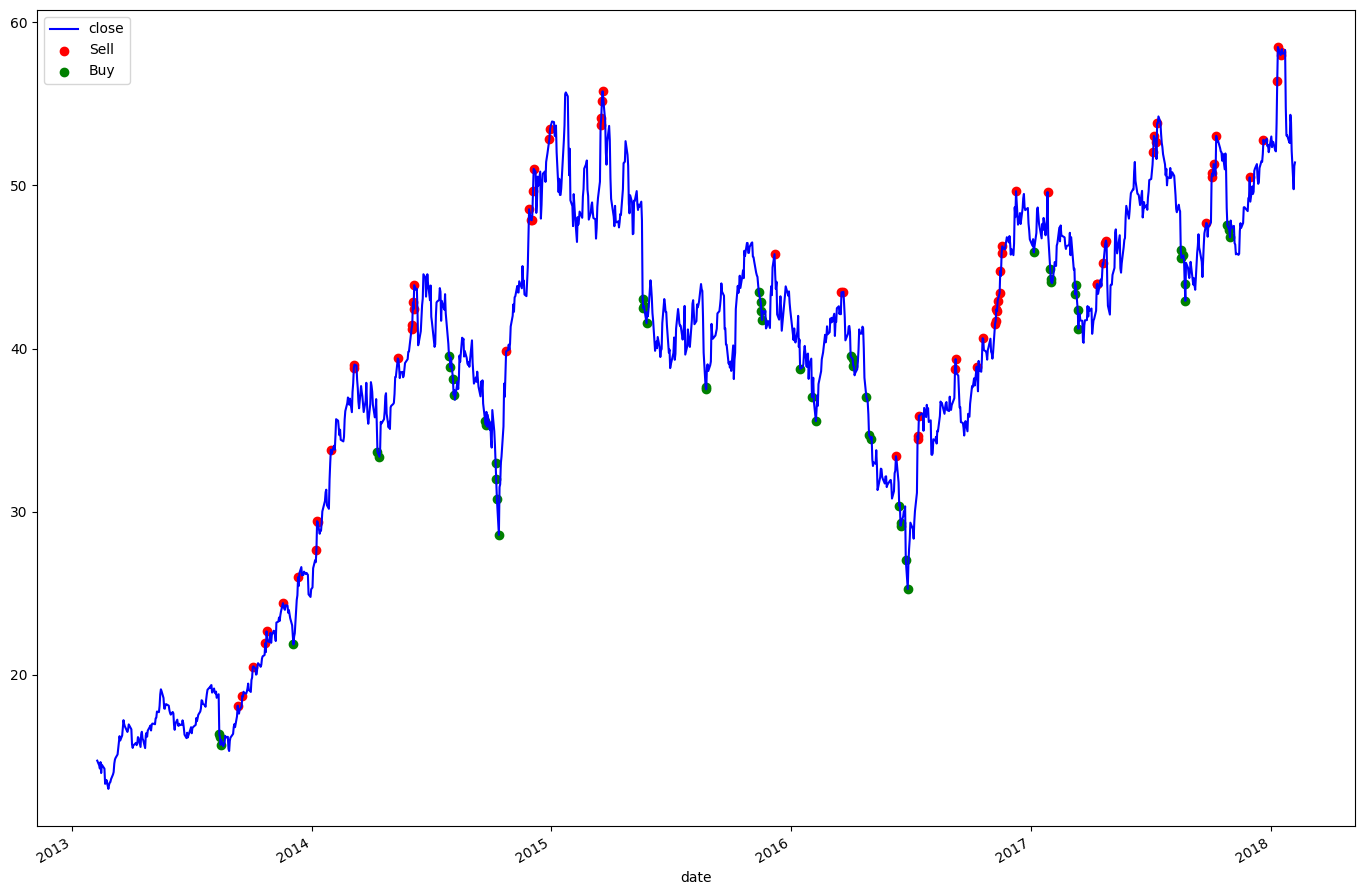

In [60]:
# plot sell and buy timestamps on the stock data
import matplotlib.pyplot as plt
from talib import BBANDS

plt.figure(figsize=(17, 12))

# plot bbands as well
# upper, middle, lower = BBANDS(stock_data['close'], timeperiod=120)
# plt.plot(stock_data.index, upper, label='Upper BB')
# plt.plot(stock_data.index, middle, label='Middle BB')
# plt.plot(stock_data.index, lower, label='Lower BB')


stock_data['close'].plot(color='blue')
plt.scatter(sell_timestamps, stock_data.loc[sell_timestamps]['close'], color='red', label='Sell')
plt.scatter(buy_timestamps, stock_data.loc[buy_timestamps]['close'], color='green', label='Buy')
# plt.scatter(hold_timestamps, stock_data.loc[hold_timestamps]['close'], color='blue', label='Hold')
plt.legend()
plt.show()


The performance of the BBands strategy is not good on its own.
But several indicators can be ranked and combined to make better decisions. 


Potentially, several indicators can be combined to make a new indicator that models different market conditions.